# Project 1

In this notebook, we will attempt to answer the following two questions:

  * What are the 5 most popular trips that you would call "commuter trips"? 
  
  * What are your recommendations for offers (justify based on your findings)?
 

In [1]:
# import necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

First, we should define what we call a "commuter trip."  Let us initially define a commuter trip as: 

* occuring only on weekdays
* not being shorter than 5 minutes and not being longer than 90 minutes
* starting and ending at different stations
* is between the hours of 5 and 20 (5 AM and 8 PM)

It is important to make certain assumptions to organize and clean the data in order to separate the 'commmuter trips' from other types of trips.  We define commuter trips to be occuring only on weekdays to better fit the typical Monday-to-Friday work schedule.  We define commuter trips as not being shorter than 5 minutes and not being longer than 90 minutes in order to remove trips that are too short and too long to be reasonably commutes from home to work.  We define commuter trips to be starting and ending at different stations because it is reasonable to assume that to commute to work, one must travel away from their initial starting point.   We define commuter trips as being between the hours of 5 and 20 (5 AM and 8 PM) to roughly follow the standard 9-5 workday.

We can now import our data given these assumptions.

In [ ]:
# ! bq query --use_legacy_sql=FALSE --max_rows=200000000 --format=csv 'SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_status`' > bike_status.csv
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_stations`' > bike_stations.csv
! bq query --use_legacy_sql=FALSE --max_rows=6000000 --format=csv 'SELECT * FROM (SELECT *,CAST(ROUND(duration_sec / 60.0) AS INT64) AS duration_minutes,CAST(ROUND(duration_sec / 3600.0) AS INT64) AS duration_hours_rounded,ROUND(duration_sec / 3600.0, 1) AS duration_hours_tenths,EXTRACT(DAYOFWEEK FROM start_date) AS dow_int,CASE EXTRACT(DAYOFWEEK FROM start_date)WHEN 1 THEN "Sunday"WHEN 2 THEN "Monday"WHEN 3 THEN "Tuesday"WHEN 4 THEN "Wednesday"WHEN 5 THEN "Thursday"WHEN 6 THEN "Friday"WHEN 7 THEN "Saturday"END AS dow_str,CASE WHEN EXTRACT(DAYOFWEEK FROM start_date) IN (1, 7) THEN "Weekend"ELSE "Weekday"END AS dow_weekday,EXTRACT(HOUR FROM start_date) AS start_hour,CASE WHEN EXTRACT(HOUR FROM start_date) <= 5  OR EXTRACT(HOUR FROM start_date) >= 23 THEN "Nightime"WHEN EXTRACT(HOUR FROM start_date) >= 6 and EXTRACT(HOUR FROM start_date) <= 8 THEN "Morning"WHEN EXTRACT(HOUR FROM start_date) >= 9 and EXTRACT(HOUR FROM start_date) <= 10 THEN "Mid Morning"WHEN EXTRACT(HOUR FROM start_date) >= 11 and EXTRACT(HOUR FROM start_date) <= 13 THEN "Mid Day"WHEN EXTRACT(HOUR FROM start_date) >= 14 and EXTRACT(HOUR FROM start_date) <= 16 THEN "Early Afternoon"WHEN EXTRACT(HOUR FROM start_date) >= 17 and EXTRACT(HOUR FROM start_date) <= 19 THEN "Afternoon"WHEN EXTRACT(HOUR FROM start_date) >= 20 and EXTRACT(HOUR FROM start_date) <= 22 THEN "Evening"END AS start_hour_str FROM `bigquery-public-data.san_francisco.bikeshare_trips`) WHERE start_station_id <> end_station_id AND duration_sec >= 300 AND duration_sec <= 324000 AND start_hour >= 5 AND start_hour <= 20 AND dow_weekday NOT LIKE "Weekend"' > bike_trips.csv

# sqlquery = """"
# SELECT *
# FROM (
# SELECT *,CAST(ROUND(duration_sec / 60.0) AS INT64) AS duration_minutes,
#        CAST(ROUND(duration_sec / 3600.0) AS INT64) AS duration_hours_rounded,
#        ROUND(duration_sec / 3600.0, 1) AS duration_hours_tenths,
#        EXTRACT(DAYOFWEEK FROM start_date) AS dow_int,
#        CASE EXTRACT(DAYOFWEEK FROM start_date)
#            WHEN 1 THEN "Sunday"
#            WHEN 2 THEN "Monday"
#            WHEN 3 THEN "Tuesday"
#            WHEN 4 THEN "Wednesday"
#            WHEN 5 THEN "Thursday"
#            WHEN 6 THEN "Friday"
#            WHEN 7 THEN "Saturday"
#            END AS dow_str,
#        CASE 
#            WHEN EXTRACT(DAYOFWEEK FROM start_date) IN (1, 7) THEN "Weekend"
#            ELSE "Weekday"
#            END AS dow_weekday,
#        EXTRACT(HOUR FROM start_date) AS start_hour,
#        CASE 
#            WHEN EXTRACT(HOUR FROM start_date) <= 5  OR EXTRACT(HOUR FROM start_date) >= 23 THEN "Nightime"
#            WHEN EXTRACT(HOUR FROM start_date) >= 6 and EXTRACT(HOUR FROM start_date) <= 8 THEN "Morning"
#            WHEN EXTRACT(HOUR FROM start_date) >= 9 and EXTRACT(HOUR FROM start_date) <= 10 THEN "Mid Morning"
#            WHEN EXTRACT(HOUR FROM start_date) >= 11 and EXTRACT(HOUR FROM start_date) <= 13 THEN "Mid Day"
#            WHEN EXTRACT(HOUR FROM start_date) >= 14 and EXTRACT(HOUR FROM start_date) <= 16 THEN "Early Afternoon"
#            WHEN EXTRACT(HOUR FROM start_date) >= 17 and EXTRACT(HOUR FROM start_date) <= 19 THEN "Afternoon"
#            WHEN EXTRACT(HOUR FROM start_date) >= 20 and EXTRACT(HOUR FROM start_date) <= 22 THEN "Evening"
#            END AS start_hour_str
# FROM `bigquery-public-data.san_francisco.bikeshare_trips`
# )
# WHERE start_station_id <> end_station_id AND duration_sec >= 300 AND dow_weekday NOT LIKE "Weekend"
# """

# ! bq query --use_legacy_sql=FALSE sqlquery > bike_trips.csv

In [2]:
# formatting datasets into pandas

trips = pd.read_csv('bike_trips.csv')
# status = pd.read_csv('bike_status.csv')
stations = pd.read_csv('bike_stations.csv')

## Part 1

### Some initial queries to explore the data



In [3]:
num_trips = trips.shape[0]
num_features = trips.shape[1]
print('Number of Recorded Trips:')
print('\t'+str(num_trips))
print('Number of Features:')
print('\t'+str(num_features))

Number of Recorded Trips:
	667713
Number of Features:
	19


In [4]:
num_stations = stations.shape[0]
num_stfeatures = stations.shape[1]
print('Number of Unique Stations:')
print('\t'+str(num_stations))
print('Number of Features:')
print('\t'+str(num_stfeatures))

Number of Unique Stations:
	74
Number of Features:
	7


In [5]:
print('Sample of Bike Trip Data:')
trips.head()

Sample of Bike Trip Data:


,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type,duration_minutes,duration_hours_rounded,duration_hours_tenths,dow_int,dow_str,dow_weekday,start_hour,start_hour_str
0,957659,587,2015-10-05 16:41:00,Sequoia Hospital,21,2015-10-05 16:51:00,Mezes,83,650,94063,Subscriber,10,0,0.2,2,Monday,Weekday,16,Early Afternoon
1,1102613,1334,2016-02-23 12:00:00,San Mateo County Center,23,2016-02-23 12:22:00,Mezes,83,174,93292,Customer,22,0,0.4,3,Tuesday,Weekday,12,Mid Day
2,1047069,1113,2015-12-25 13:17:00,San Mateo County Center,23,2015-12-25 13:35:00,Mezes,83,149,94063,Subscriber,19,0,0.3,6,Friday,Weekday,13,Mid Day
3,1029835,301,2015-12-04 17:32:00,Redwood City Caltrain Station,22,2015-12-04 17:37:00,Mezes,83,155,94063,Subscriber,5,0,0.1,6,Friday,Weekday,17,Afternoon
4,987584,325,2015-10-27 17:32:00,Redwood City Caltrain Station,22,2015-10-27 17:38:00,Mezes,83,52,94063,Subscriber,5,0,0.1,3,Tuesday,Weekday,17,Afternoon


In [6]:
print('Sample of Station Data:')
stations.head()

Sample of Station Data:


,station_id,name,latitude,longitude,dockcount,landmark,installation_date
0,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-06
1,37,Cowper at University,37.448598,-122.159504,11,Palo Alto,2013-08-14
2,35,University and Emerson,37.444521,-122.163093,11,Palo Alto,2013-08-15
3,32,Castro Street and El Camino Real,37.385956,-122.083678,11,Mountain View,2013-12-31
4,84,Ryland Park,37.342725,-121.895617,15,San Jose,2014-04-09


Let's take a look at the overall distribution of trips over the days of the week.

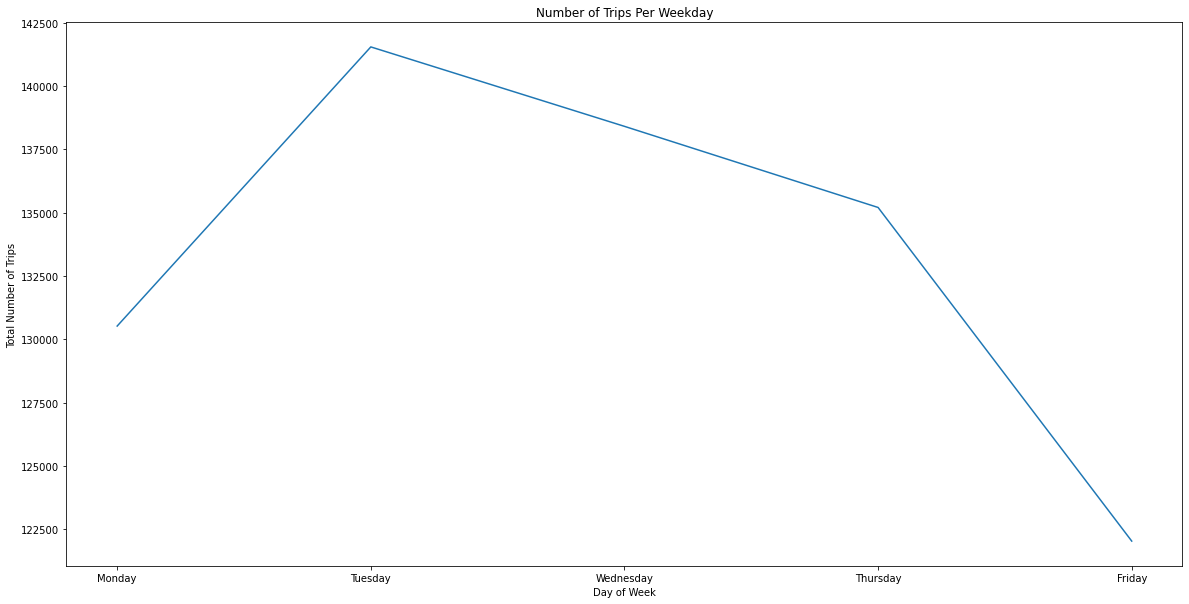

In [7]:
sortedtrips = trips
sortedtrips['dow_str'] = pd.Categorical(trips['dow_str'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday'],ordered=True)
tripdates = sortedtrips.groupby('dow_str').count()

tripdates.head()
startdates = list(tripdates.index.values)
count_startdates = list(tripdates['start_date'])
plt.figure(figsize=(20,10))
plt.plot(startdates,count_startdates)
# plt.xticks(rotation='vertical')
plt.title('Number of Trips Per Weekday')
plt.xlabel('Day of Week')
plt.ylabel('Total Number of Trips')

plt.show()

Let's take a look at the overall distribution over the times of the day.

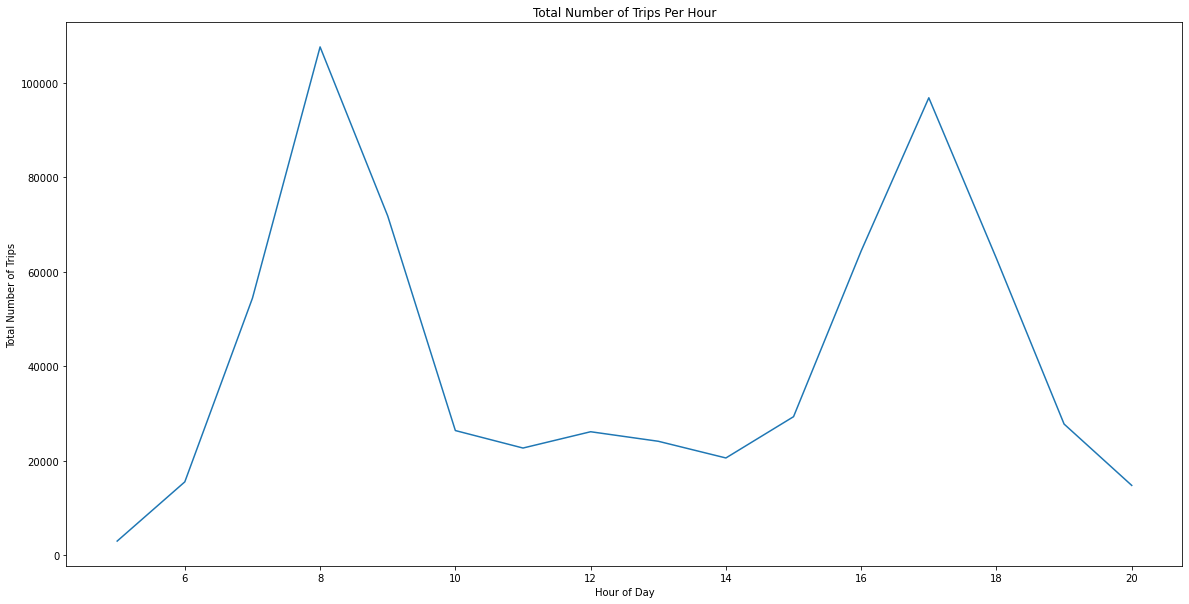

In [8]:
sortedtrips = trips.groupby('start_hour').count()
# sortedtrips
starthour = list(sortedtrips.index.values)
count_starthour = list(sortedtrips['start_station_id'])
plt.figure(figsize=(20,10))
plt.plot(starthour,count_starthour)
# plt.xticks(rotation='vertical')
plt.title('Total Number of Trips Per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Total Number of Trips')

plt.show()

From the distribution of trips per hour, we can see two peaks that roughly correspond to the typical 9-5 workday: the first peak is centered at 8 AM , and the second peak is centered at 5 PM.  We will take these two peaks to be our dataset of commuter trips.  Visually judging from the distributions, morning commuter trips will be defined as trips from 6 AM to 10 AM, and evening commuter trips will be defined as trips from 3 PM to 7 PM.

In [9]:
morningtrips = trips[(trips['start_hour']>=5) & (trips['start_hour']<=10)]
morningtrips.head()

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type,duration_minutes,duration_hours_rounded,duration_hours_tenths,dow_int,dow_str,dow_weekday,start_hour,start_hour_str
30,418464,488,2014-08-21 10:15:00,MLK Library,11,2014-08-21 10:23:00,Japantown,9,646,95113,Subscriber,8,0,0.1,5,Thursday,Weekday,10,Mid Morning
40,277589,522,2014-05-09 07:22:00,MLK Library,11,2014-05-09 07:31:00,Japantown,9,685,95112,Subscriber,9,0,0.1,6,Friday,Weekday,7,Morning
44,481709,545,2014-10-03 09:58:00,MLK Library,11,2014-10-03 10:07:00,Japantown,9,77,95112,Subscriber,9,0,0.2,6,Friday,Weekday,9,Mid Morning
45,856546,1050,2015-07-22 05:27:00,MLK Library,11,2015-07-22 05:45:00,Japantown,9,20,94104,Subscriber,18,0,0.3,4,Wednesday,Weekday,5,Nightime
48,446289,455,2014-09-10 10:33:00,MLK Library,11,2014-09-10 10:41:00,Japantown,9,128,95113,Subscriber,8,0,0.1,4,Wednesday,Weekday,10,Mid Morning


In [10]:
num_trips = morningtrips.shape[0]
num_features = morningtrips.shape[1]
print('Number of Recorded Morning Trips:')
print('\t'+str(num_trips))
print('Number of Features:')
print('\t'+str(num_features))

Number of Recorded Morning Trips:
	278578
Number of Features:
	19


In [11]:
eveningtrips = trips[(trips['start_hour']>=15) & (trips['start_hour']<=19)]
eveningtrips.head()

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type,duration_minutes,duration_hours_rounded,duration_hours_tenths,dow_int,dow_str,dow_weekday,start_hour,start_hour_str
0,957659,587,2015-10-05 16:41:00,Sequoia Hospital,21,2015-10-05 16:51:00,Mezes,83,650,94063,Subscriber,10,0,0.2,2,Monday,Weekday,16,Early Afternoon
3,1029835,301,2015-12-04 17:32:00,Redwood City Caltrain Station,22,2015-12-04 17:37:00,Mezes,83,155,94063,Subscriber,5,0,0.1,6,Friday,Weekday,17,Afternoon
4,987584,325,2015-10-27 17:32:00,Redwood City Caltrain Station,22,2015-10-27 17:38:00,Mezes,83,52,94063,Subscriber,5,0,0.1,3,Tuesday,Weekday,17,Afternoon
5,1009081,385,2015-11-13 17:09:00,Redwood City Caltrain Station,22,2015-11-13 17:15:00,Mezes,83,199,94063,Subscriber,6,0,0.1,6,Friday,Weekday,17,Afternoon
6,1051301,428,2016-01-04 17:08:00,Redwood City Caltrain Station,22,2016-01-04 17:15:00,Mezes,83,185,94063,Subscriber,7,0,0.1,2,Monday,Weekday,17,Afternoon


In [12]:
num_trips = eveningtrips.shape[0]
num_features = eveningtrips.shape[1]
print('Number of Recorded Evening Trips:')
print('\t'+str(num_trips))
print('Number of Features:')
print('\t'+str(num_features))

Number of Recorded Evening Trips:
	281049
Number of Features:
	19


Now, we can explore the distribution of the duration of these commuter trips.

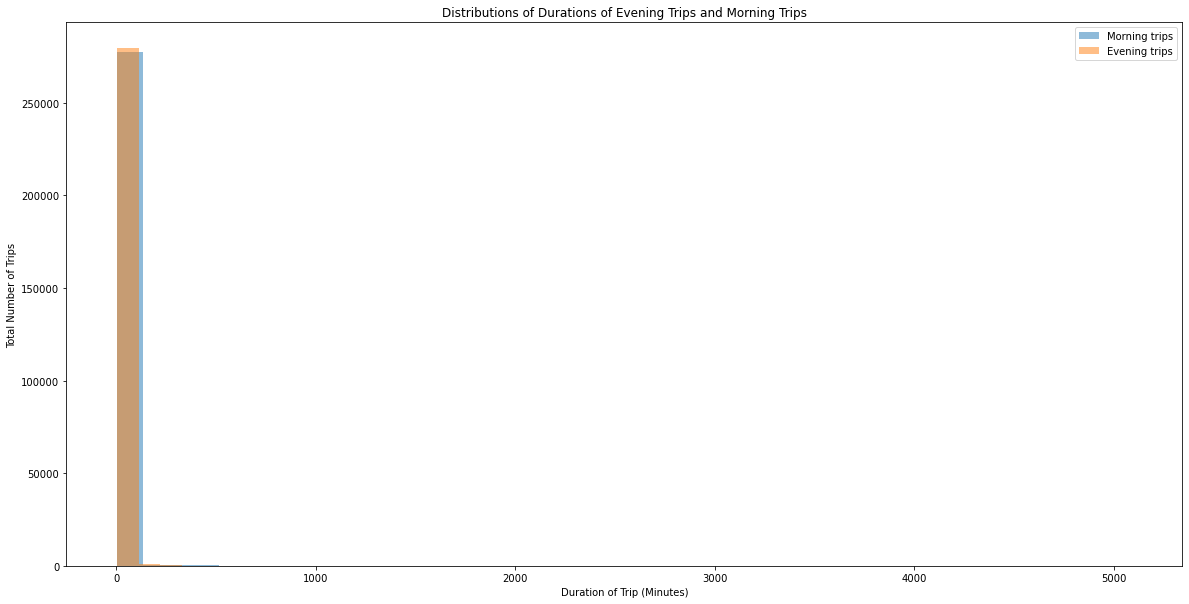

In [13]:
plt.figure(figsize=(20,10))
plt.hist(morningtrips['duration_minutes'], bins=40, label='Morning trips', alpha = 0.5)
plt.hist(eveningtrips['duration_minutes'], bins=40, label='Evening trips', alpha = 0.5)
plt.title('Distributions of Durations of Evening Trips and Morning Trips')
plt.xlabel('Duration of Trip (Minutes)')
plt.ylabel('Total Number of Trips')
plt.legend()
plt.show()


# plt.figure(figsize=(20,10))
# plt.hist(morningtrips['duration_minutes'])
# # plt.xticks(rotation='vertical')
# plt.title('Distribution of Duration of Morning Trips')
# plt.xlabel('Duration of Trip')
# plt.ylabel('Total Number of Trips')

# plt.show()

From the above, we can see that the vast majority of both morning and evening trips last between 0 and 400 minutes.  To suit the majority of these commuters, we will reformat our data to exclude the extreme outliers.

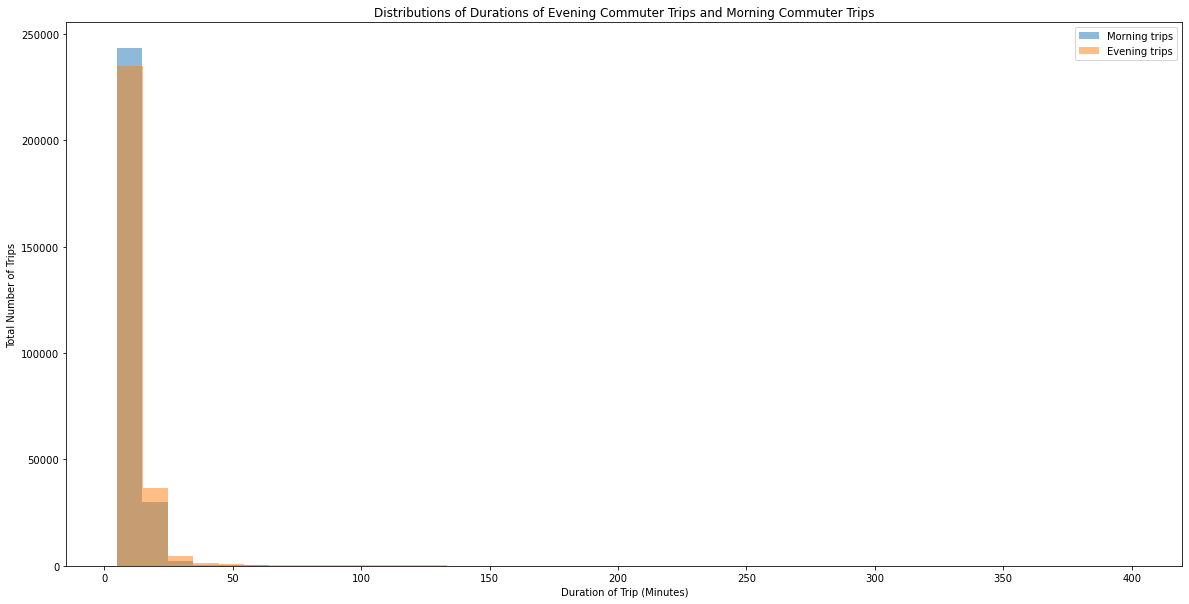

In [14]:
morningtrips = morningtrips[(morningtrips['duration_minutes']>0) & (morningtrips['duration_minutes']<=400)]
eveningtrips = eveningtrips[(eveningtrips['duration_minutes']>0) & (eveningtrips['duration_minutes']<=400)]

plt.figure(figsize=(20,10))
plt.hist(morningtrips['duration_minutes'], bins=40, label='Morning trips', alpha = 0.5)
plt.hist(eveningtrips['duration_minutes'], bins=40, label='Evening trips', alpha = 0.5)
plt.title('Distributions of Durations of Evening Commuter Trips and Morning Commuter Trips')
plt.xlabel('Duration of Trip (Minutes)')
plt.ylabel('Total Number of Trips')
plt.legend()
plt.show()

# plt.figure(figsize=(20,10))
# plt.hist(morningtrips['duration_minutes'])
# # plt.xticks(rotation='vertical')
# plt.title('Distribution of Duration of Morning Trips')
# plt.xlabel('Duration of Trip')
# plt.ylabel('Total Number of Trips')

# plt.show()

Let's zoom in on the distribution of trips that last less than 50 minutes.

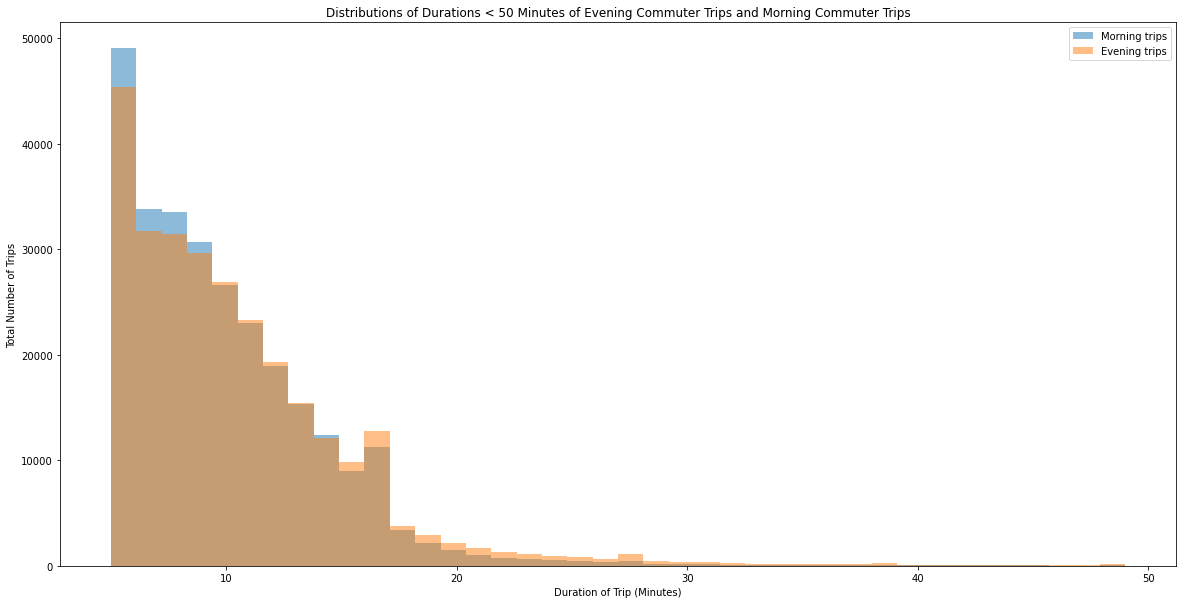

In [15]:
plt.figure(figsize=(20,10))
plt.hist(morningtrips[morningtrips['duration_minutes']<50]['duration_minutes'], bins=40, label='Morning trips', alpha = 0.5)
plt.hist(eveningtrips[eveningtrips['duration_minutes']<50]['duration_minutes'], bins=40, label='Evening trips', alpha = 0.5)
plt.title('Distributions of Durations < 50 Minutes of Evening Commuter Trips and Morning Commuter Trips')
plt.xlabel('Duration of Trip (Minutes)')
plt.ylabel('Total Number of Trips')
plt.legend()
plt.show()


These visualizations for evening and morning trip duration distributions are fairly similar.  While this is not necessarily a guarantee that our data is exactly aligned with commuter trips, it's a good sign that it at least fits into our assumptions for what commuter trips should look like (i.e. trips to and from work should be symmetrical).  We can double check that these distributions are similar by comparing their means and standard deviation.

In [16]:
print('Average duration of morning trips: '+ str(morningtrips['duration_minutes'].mean()))
print('Average duration of morning trips: '+ str(eveningtrips['duration_minutes'].mean()))
print()
print('Standard deviation of durations of morning trips: '+ str(morningtrips['duration_minutes'].std()))
print('Standard deviation of durations of morning trips: '+ str(eveningtrips['duration_minutes'].std()))

Average duration of morning trips: 11.071015935896929
Average duration of morning trips: 11.828853573298849

Standard deviation of durations of morning trips: 14.811788956308737
Standard deviation of durations of morning trips: 14.06040021989335


The means and standard deviation are fairly similar, which corroborates the hypothetical symmetry between the morning and evening commuter trips.

Another feature of interest would be stations: where are people coming from and where are they going?

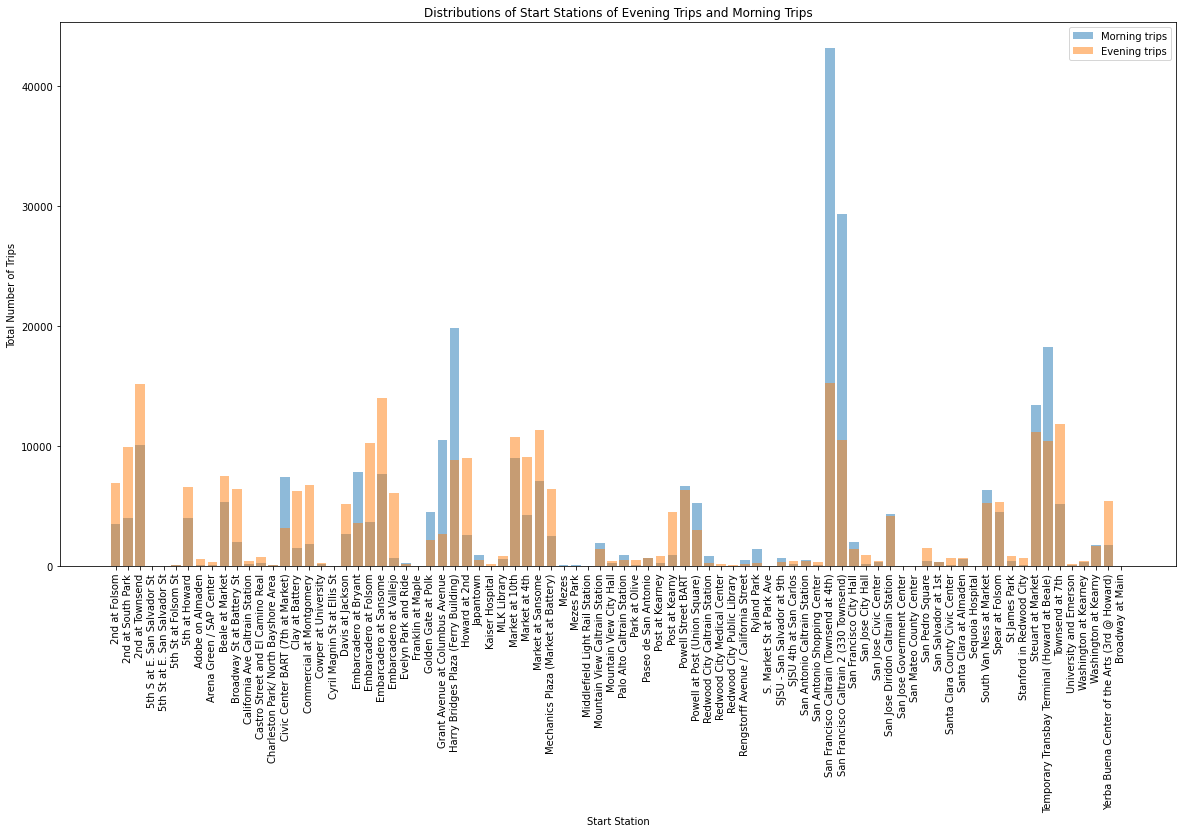

In [17]:
morningtripstations = morningtrips.groupby('start_station_name').count()
eveningtripstations = eveningtrips.groupby('start_station_name').count()

morningindex = list(morningtripstations.index.values)
morningcontents = list(morningtripstations['start_station_id'])

eveningindex = list(eveningtripstations.index.values)
eveningcontents = list(eveningtripstations['start_station_id'])

plt.figure(figsize=(20,10))
plt.bar(morningindex, morningcontents, label='Morning trips', alpha = 0.5)
plt.bar(eveningindex, eveningcontents, label='Evening trips', alpha = 0.5)
plt.title('Distributions of Start Stations of Evening Trips and Morning Trips')
plt.xlabel('Start Station')
plt.ylabel('Total Number of Trips')
plt.xticks(rotation='vertical')

plt.legend()
plt.show()


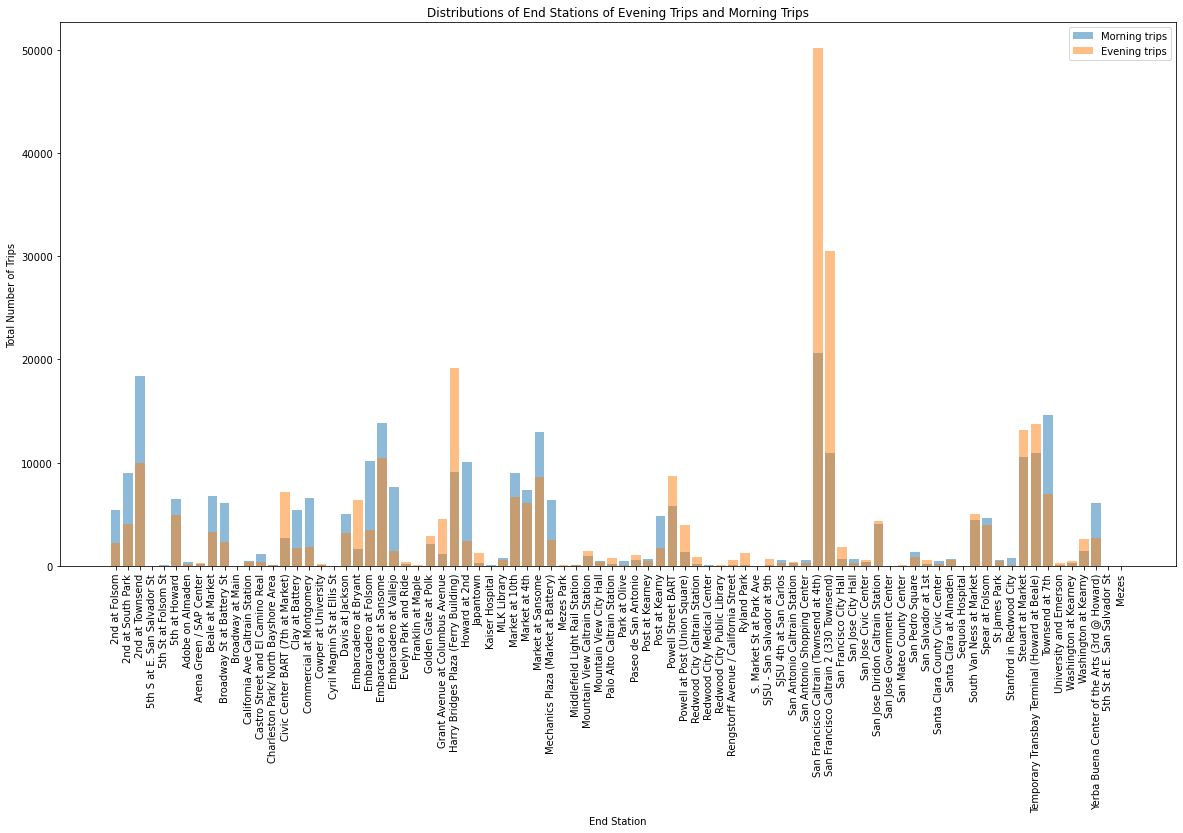

In [18]:
morningtripstations = morningtrips.groupby('end_station_name').count()
eveningtripstations = eveningtrips.groupby('end_station_name').count()

morningindex = list(morningtripstations.index.values)
morningcontents = list(morningtripstations['start_station_id'])

eveningindex = list(eveningtripstations.index.values)
eveningcontents = list(eveningtripstations['start_station_id'])

plt.figure(figsize=(20,10))
plt.bar(morningindex, morningcontents, label='Morning trips', alpha = 0.5)
plt.bar(eveningindex, eveningcontents, label='Evening trips', alpha = 0.5)
plt.title('Distributions of End Stations of Evening Trips and Morning Trips')
plt.xlabel('End Station')
plt.ylabel('Total Number of Trips')
plt.xticks(rotation='vertical')

plt.legend()
plt.show()


When we compare the two charts, we can see a certain symmetry between the start stations of morning trips and the end stations of evening trips.  Similarly, there is a certain symmetry between the end stations of morning trips and the start stations of evening trips.  Let's examine these similarities further.

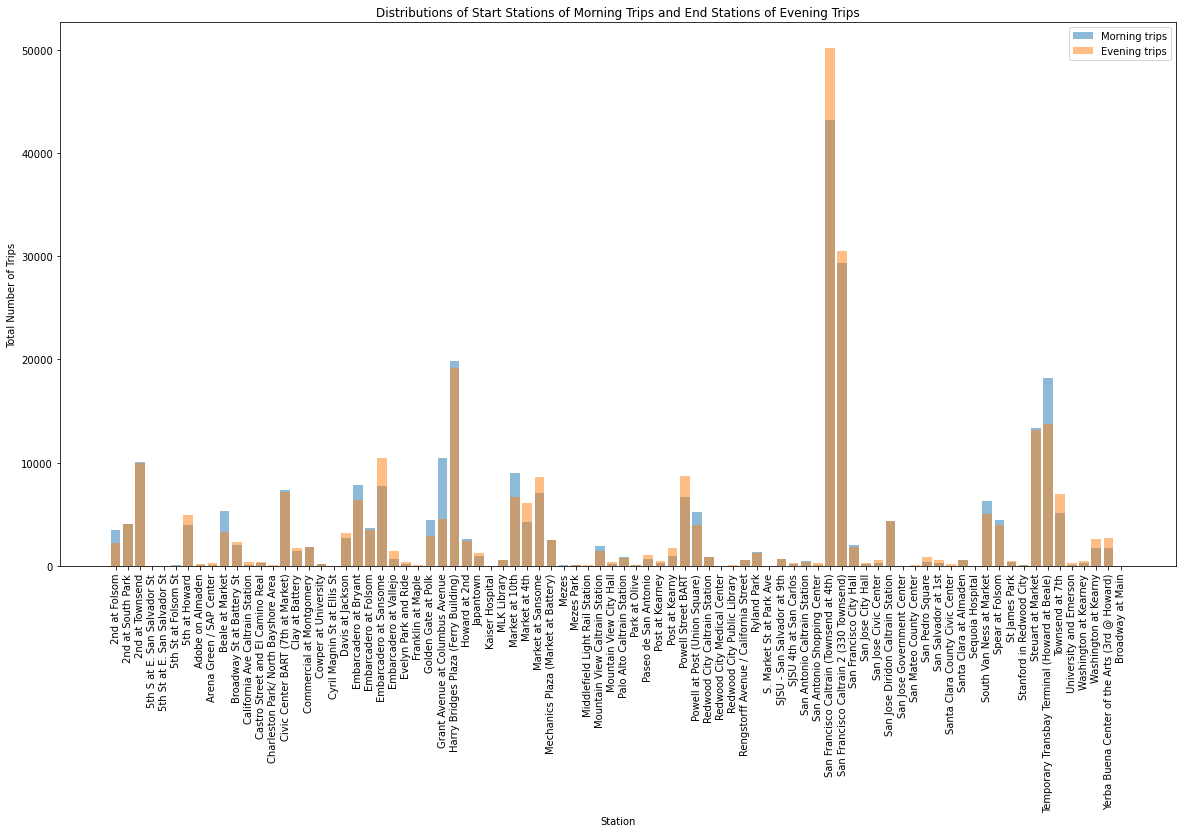

In [19]:
morningtripstations = morningtrips.groupby('start_station_name').count()
eveningtripstations = eveningtrips.groupby('end_station_name').count()

morningindex = list(morningtripstations.index.values)
morningcontents = list(morningtripstations['start_station_id'])

eveningindex = list(eveningtripstations.index.values)
eveningcontents = list(eveningtripstations['end_station_id'])

plt.figure(figsize=(20,10))
plt.bar(morningindex, morningcontents, label='Morning trips', alpha = 0.5)
plt.bar(eveningindex, eveningcontents, label='Evening trips', alpha = 0.5)
plt.title('Distributions of Start Stations of Morning Trips and End Stations of Evening Trips')
plt.xlabel('Station')
plt.ylabel('Total Number of Trips')
plt.xticks(rotation='vertical')

plt.legend()
plt.show()


We can see that the distributions of the start stations of morning trips and the end stations of evening trips are actually quite similar, which is something that we should expect of commuter trips: commuters will leave from a station near their home, and will likely return from work to that same station near that home.

<function matplotlib.pyplot.show(close=None, block=None)>

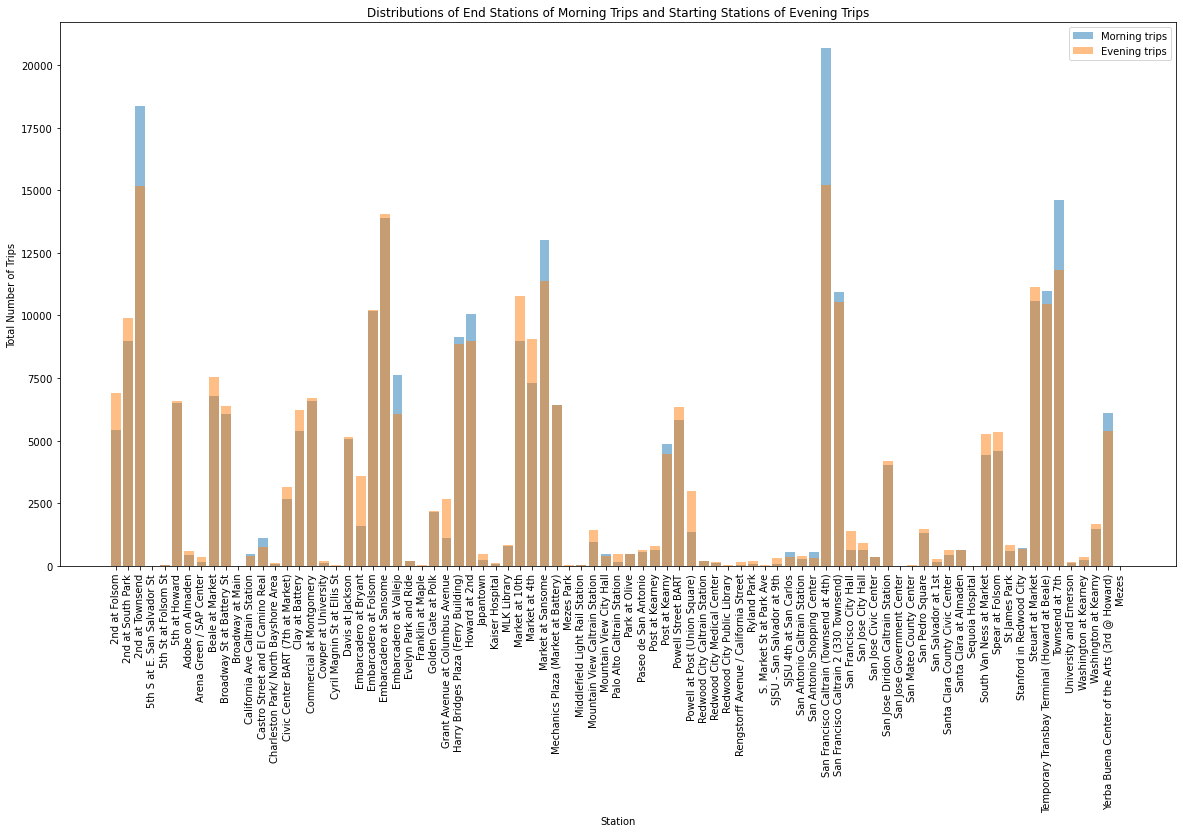

In [20]:
morningtripstations = morningtrips.groupby('end_station_name').count()
eveningtripstations = eveningtrips.groupby('start_station_name').count()

morningindex = list(morningtripstations.index.values)
morningcontents = list(morningtripstations['end_station_id'])

eveningindex = list(eveningtripstations.index.values)
eveningcontents = list(eveningtripstations['start_station_id'])

plt.figure(figsize=(20,10))
plt.bar(morningindex, morningcontents, label='Morning trips', alpha = 0.5)
plt.bar(eveningindex, eveningcontents, label='Evening trips', alpha = 0.5)
plt.title('Distributions of End Stations of Morning Trips and Starting Stations of Evening Trips')
plt.xlabel('Station')
plt.ylabel('Total Number of Trips')
plt.xticks(rotation='vertical')

plt.legend()
plt.show

Similarly, we can see that the distributions of the end stations of morning trips and the starting stations of evening trips are actually quite similar, which is something that we should expect of commuter trips: commters will travel from their homes to an end station near their work, and will likely leave work from that same station to return home.

# Determining the Most Popular Commuter Trips

The above analysis of trip duration and trip start/end stations are intended to help ensure that we are working with data specifically tailored toward commuter trips.  Now that we are working with commuter data, we can determine what the most popular trips are within this commuter data. In theory, the most popular start-to-end station morning trips should be equivalent to the start-to-end station evening trips, as we would expect commuters to go from home to work in the morning and work to home in the evening.

From our existing data, let's join the start station names with the end station names to create a new 'trips' feature that is comprised of the start station to end station pairs.  Let's also create another hypothetical 'reverse' feature that is comprised of the end station to start station pairs (reverse order to 'trips').  We will use this 'reverse' feature to check when people are going from home to work then work to home. (i.e. morning trips should equal the reverse of evening trips, and evening trips should equal the reverse of morning trips.)

In [21]:
morningtrips['trip'] = morningtrips.start_station_name+" to "+morningtrips.end_station_name
eveningtrips['trip'] = eveningtrips.start_station_name+" to "+eveningtrips.end_station_name

morningtrips['reverse'] = morningtrips.end_station_name+" to "+morningtrips.start_station_name
eveningtrips['reverse'] = eveningtrips.end_station_name+" to "+eveningtrips.start_station_name

# morningtrips.loc[:, "trip"] = morningtrips.[]

In [22]:
morningtrips['trip']

30                                 MLK Library to Japantown
40                                 MLK Library to Japantown
44                                 MLK Library to Japantown
45                                 MLK Library to Japantown
48                                 MLK Library to Japantown
                                ...                        
667702    Temporary Transbay Terminal (Howard at Beale) ...
667703    Temporary Transbay Terminal (Howard at Beale) ...
667705    Temporary Transbay Terminal (Howard at Beale) ...
667707    Temporary Transbay Terminal (Howard at Beale) ...
667711    Temporary Transbay Terminal (Howard at Beale) ...
Name: trip, Length: 278177, dtype: object

In [23]:
eveningtrips['trip']

0                                 Sequoia Hospital to Mezes
3                    Redwood City Caltrain Station to Mezes
4                    Redwood City Caltrain Station to Mezes
5                    Redwood City Caltrain Station to Mezes
6                    Redwood City Caltrain Station to Mezes
                                ...                        
667692    Temporary Transbay Terminal (Howard at Beale) ...
667695    Temporary Transbay Terminal (Howard at Beale) ...
667697    Temporary Transbay Terminal (Howard at Beale) ...
667704    Temporary Transbay Terminal (Howard at Beale) ...
667710    Temporary Transbay Terminal (Howard at Beale) ...
Name: trip, Length: 280707, dtype: object

In [24]:
morningtripcounts = morningtrips.groupby('trip').count().sort_values(by=['trip_id'], ascending=False)
morningreversetripcounts = morningtrips.groupby('reverse').count().sort_values(by=['trip_id'], ascending=False)

eveningtripcounts = eveningtrips.groupby('trip').count().sort_values(by=['trip_id'], ascending=False)
eveningreversetripcounts = eveningtrips.groupby('reverse').count().sort_values(by=['trip_id'], ascending=False)

In [25]:
morningtripcounts.loc[:, "count"] = morningtripcounts['trip_id']
morningreversetripcounts.loc[:, "count"] = morningreversetripcounts['trip_id']

eveningtripcounts.loc[:, "count"] = eveningtripcounts['trip_id']
eveningreversetripcounts.loc[:, "count"] = eveningreversetripcounts['trip_id']

In [26]:
print('Five Most Popular Morning Commuter Trips:')
morningtripcounts[['count']].head()

Five Most Popular Morning Commuter Trips:


,count
trip,
Harry Bridges Plaza (Ferry Building) to 2nd at Townsend,4916
San Francisco Caltrain (Townsend at 4th) to Temporary Transbay Terminal (Howard at Beale),4348
Steuart at Market to 2nd at Townsend,4126
San Francisco Caltrain (Townsend at 4th) to Embarcadero at Folsom,3709
San Francisco Caltrain (Townsend at 4th) to Harry Bridges Plaza (Ferry Building),3334


In [27]:
print('Predicted Five Most Popular Morning Commuter Trips (Based on Evening Commuter Trips):')
eveningreversetripcounts[['count']].head()

Predicted Five Most Popular Morning Commuter Trips (Based on Evening Commuter Trips):


,count
reverse,
Harry Bridges Plaza (Ferry Building) to 2nd at Townsend,5039
San Francisco Caltrain (Townsend at 4th) to Embarcadero at Folsom,4875
San Francisco Caltrain (Townsend at 4th) to Temporary Transbay Terminal (Howard at Beale),4129
San Francisco Caltrain (Townsend at 4th) to Steuart at Market,4051
Steuart at Market to Embarcadero at Sansome,3862


In [28]:
print('Five Most Popular Evening Commuter Trips:')
eveningtripcounts[['count']].head()

Five Most Popular Evening Commuter Trips:


,count
trip,
2nd at Townsend to Harry Bridges Plaza (Ferry Building),5039
Embarcadero at Folsom to San Francisco Caltrain (Townsend at 4th),4875
Temporary Transbay Terminal (Howard at Beale) to San Francisco Caltrain (Townsend at 4th),4129
Steuart at Market to San Francisco Caltrain (Townsend at 4th),4051
Embarcadero at Sansome to Steuart at Market,3862


In [29]:
print('Predicted Five Most Popular Evening Commuter Trips (Based on Morning Commuter Trips):')
morningreversetripcounts[['count']].head()

Predicted Five Most Popular Evening Commuter Trips (Based on Morning Commuter Trips):


,count
reverse,
2nd at Townsend to Harry Bridges Plaza (Ferry Building),4916
Temporary Transbay Terminal (Howard at Beale) to San Francisco Caltrain (Townsend at 4th),4348
2nd at Townsend to Steuart at Market,4126
Embarcadero at Folsom to San Francisco Caltrain (Townsend at 4th),3709
Harry Bridges Plaza (Ferry Building) to San Francisco Caltrain (Townsend at 4th),3334


From the above, we can tell that the most popular trip is clearly the "Harry Bridges Plaza (Ferry Building) to 2nd at Townsend", as it is the most popular trip for both evening and morning commutes.  We also see some similarities between our predicted popular trips and the actual popular trips, but there are notable differences.  The four other most popular trips are a little less clear; contenders include "San Francisco Caltrain (Townsend at 4th) to Temporary Transbay Terminal (Howard at Beale)" and "San Francisco Caltrain (Townsend at 4th) to Embarcadero at Folsom" are also both in the top five trips for both evening and morning commutes (although ranked differently for each).  But in general, from this metric, the four most popular trips are a little difficult to rank.

To fix this issue, we will add actual counts of morning commute trips to the counts of evening commute trips (reversed) and use the aggregate sum to determine a more conclusive ranking.

In [30]:
# combinedtripcounts = morningtripcounts[['count']].add(eveningreversetripcounts[['count']], fill_value=0)
combinedtripcounts = morningtripcounts.add(eveningreversetripcounts, fill_value=0).sort_values(by=['count'], ascending=False)

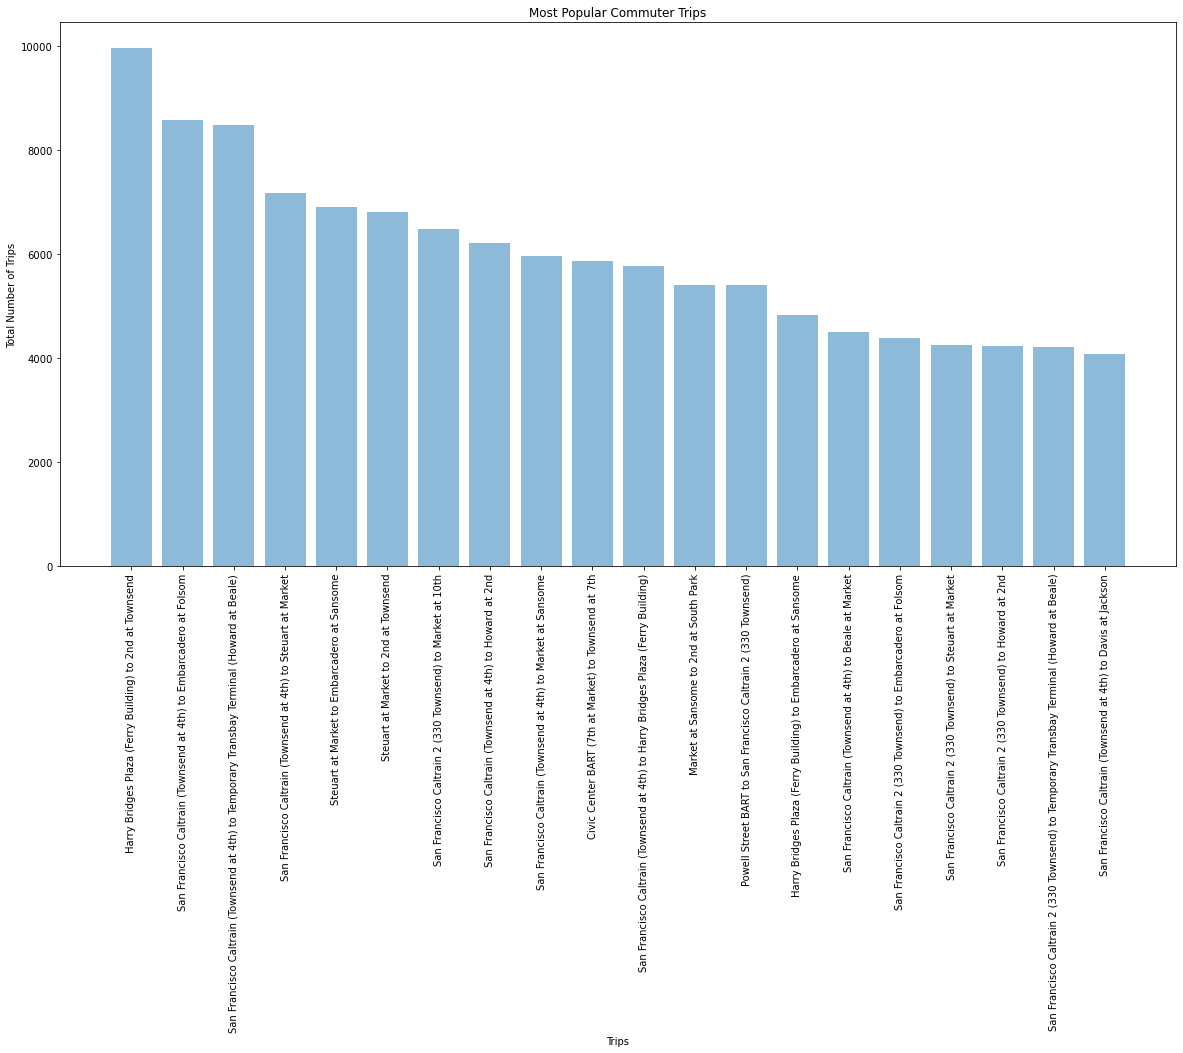

In [31]:
plotcombinedtripcounts = combinedtripcounts.head(20)
stationindex = list(plotcombinedtripcounts.index.values)
stationcontents = list(plotcombinedtripcounts['count'])

plt.figure(figsize=(20,10))
plt.bar(stationindex, stationcontents, alpha = 0.5)
plt.title('Most Popular Commuter Trips')
plt.xlabel('Trips')
plt.ylabel('Total Number of Trips')
plt.xticks(rotation='vertical')

plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

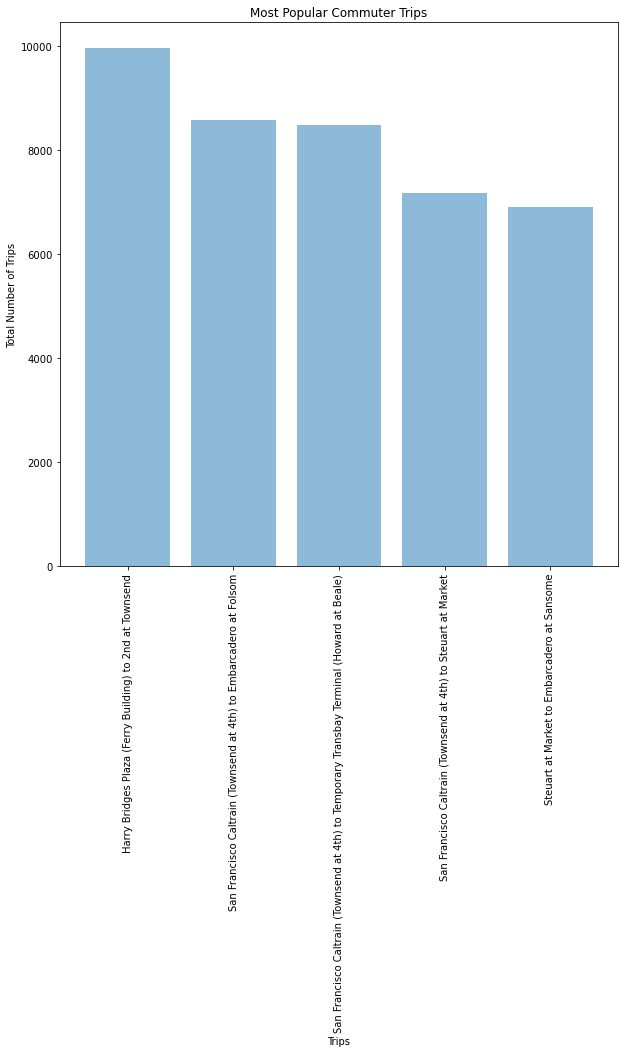

In [32]:
plotcombinedtripcounts = combinedtripcounts.head(5)
stationindex = list(plotcombinedtripcounts.index.values)
stationcontents = list(plotcombinedtripcounts['count'])

plt.figure(figsize=(10,10))
plt.bar(stationindex, stationcontents, alpha = 0.5)
plt.title('Most Popular Commuter Trips')
plt.xlabel('Trips')
plt.ylabel('Total Number of Trips')
plt.xticks(rotation='vertical')

plt.show

In [33]:
combinedtripcounts[['count']].head()

,count
Harry Bridges Plaza (Ferry Building) to 2nd at Townsend,9955.0
San Francisco Caltrain (Townsend at 4th) to Embarcadero at Folsom,8584.0
San Francisco Caltrain (Townsend at 4th) to Temporary Transbay Terminal (Howard at Beale),8477.0
San Francisco Caltrain (Townsend at 4th) to Steuart at Market,7165.0
Steuart at Market to Embarcadero at Sansome,6896.0


Therefore, the five most popular commuter trips are:

* Harry Bridges Plaza (Ferry Building) to/from 2nd at Townsend
* San Francisco Caltrain (Townsend at 4th) to/from Embarcadero at Folsom
* San Francisco Caltrain (Townsend at 4th) to/from Temporary Transbay Terminal (Howard at Beale)
* San Francisco Caltrain (Townsend at 4th) to/from Steuart at Market
* Steuart at Market to/from Embarcadero at Sansome



# Recommending Offers

Before we recommend offers, let's take a look at the current pricing models:


* Taking a single ride
    * A single ride costs \$2 and lasts 30 minutes — enough time to head to your favorite restaurant, meet up with friends, or run a quick errand. 
    * Need more time? Each additional 15 minutes costs \$3.
    
    
    
* Monthly membership
    * Unlimited number of 45-minute rides for 30 days from purchase. This membership costs \$15 per month, with no annual commitment.  
    * If your ride lasts longer than 45-minutes, you’ll be charged another \$3 every 15 minutes. 


* Annual memberships
    * \$149/ yr Annual Membership includes:
    * Unlimited 45-minute rides for a full year
    * 24/7 access to thousands of bikes in San Francisco, East Bay, and San Jose
    * Trips longer than 45 minutes will incur an extra \\$3 per each additional 45-minutes. Usage fees are charged at the end of every ride. The fee for a lost or stolen bike is \$1,200 (+ tax).


* Using an Access Pass
    * For \$10, our Access Pass gives you an unlimited number of 30-minute rides over a 24-hour period. 
    * If you keep a bike out for longer than this time frame, you’ll be charged $3 per each additional 15 minutes. 

There is also Corporate Memberships that varies per organization, as well as a Bike Share for All program for income-eligible customers, but for our purposes we'll focus on the main pricing models: Easy Pass, Individual Rides, Monthly Membership, and Annual Memberships.

Let's see how much the average commuter will pay per year under each of these pricing models.

### Access Pass

Assume that a commuter will take two trips (both trips under 30 minutes) every 5 days of every week for a year under the access pass model.

In [34]:
daysinayear=365
fracweekdays = 5/7
weekdaysinayear = round(365*fracweekdays)

cost = 10
dailycost = cost
yearlycost = dailycost*weekdaysinayear

print('Access Pass Commuter Cost Per Year:')
print('$'+str(yearlycost))

Access Pass Commuter Cost Per Year:
$2610


### Single Ride 

Assume that a commuter will take two trips (both trips under 30 minutes) every 5 days of every week for a year under the single ride model.

In [35]:
daysinayear=365
fracweekdays = 5/7
weekdaysinayear = round(365*fracweekdays)

cost = 2
dailycost = cost*2
yearlycost = dailycost*weekdaysinayear

print('Single Ride Commuter Cost Per Year:')
print('$'+str(yearlycost))

Single Ride Commuter Cost Per Year:
$1044


### Monthly membership

Assume that a commuter will take two trips (both trips under 30 minutes) every 5 days of every week for a year under the monthly membership model.

In [36]:
monthlycost = 15
yearlycost = 12*15

print('Monthly Membership Commuter Cost Per Year:')
print('$'+str(yearlycost))

Monthly Membership Commuter Cost Per Year:
$180


### Yearly membership

Assume that a commuter will take two trips (both trips under 30 minutes) every 5 days of every week for a year under the yearly membership model.

In [37]:
yearlycost = 149

print('Yearly Membership Commuter Cost Per Year:')
print('$'+str(yearlycost))

Yearly Membership Commuter Cost Per Year:
$149


We can see that cheapest option for San Francisco commuters is the Yearly Membership at \\$149.  Let's try to create a 'Commuter' Membership that could appeal to San Francisco commuters.

## Duration

As we can see from the Single Ride, Monthly Membership, Annual Membership models, the duration of the ride is central to each pricing model.  Let's go back and examine the distribution of the ride durations in our commuter dataset.

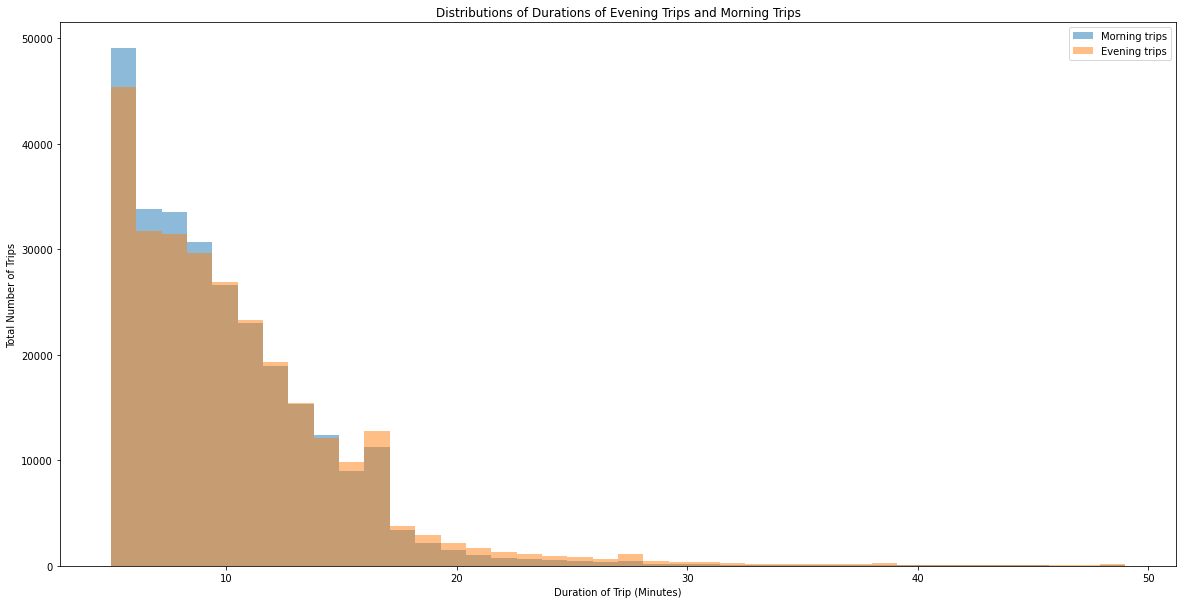

In [38]:
plt.figure(figsize=(20,10))
plt.hist(morningtrips[morningtrips['duration_minutes']<50]['duration_minutes'], bins=40, label='Morning trips', alpha = 0.5)
plt.hist(eveningtrips[eveningtrips['duration_minutes']<50]['duration_minutes'], bins=40, label='Evening trips', alpha = 0.5)
plt.title('Distributions of Durations of Evening Trips and Morning Trips')
plt.xlabel('Duration of Trip (Minutes)')
plt.ylabel('Total Number of Trips')
plt.legend()
plt.show()


By visually examining our dataset, we can see that the vast majority of commuter ride are under 20 minutes.

In [39]:
commutes =  pd.concat([morningtrips, eveningtrips])
print('Mean duration of commter rides:')
print(str(commutes['duration_minutes'].mean())+' minutes')
print('Percentage of commuter rides under 20 minutes:')
print(str(commutes[commutes['duration_minutes']<=20].shape[0]/commutes.shape[0]* 100)+'%')

Mean duration of commter rides:
11.451650074076195 minutes
Percentage of commuter rides under 20 minutes:
96.05338496002749%


Seeing this, we can see an opportunity here to offer a new plan based on these shorter commute times.  The current Annual Membership and Monthly Membership offer unlimited 45 minute rides while active, but we can see that the full 45 minutes often aren't necessary.  

# Recommendation 1

We can offer cheaper plans that offer less minutes in order to attract more commuters.  Most commuters don't use the full 45 minutes, so we can offer them something fewer minutes at lower prices.  For example, a Yearly Commuter Membership that offers unlimited 25 minute rides for \\$100 a year, or a Monthly Commuter Membership that offers unlimited 25 minute rides for \\$10 a month.  It would be important to market these specifically to commuters in San Francisco, in order for the shorter minutes to be appealing to customers.

## Location

Another thing we have to look it is location.  Let's re-examine the distributions of which stations commuters use most often.

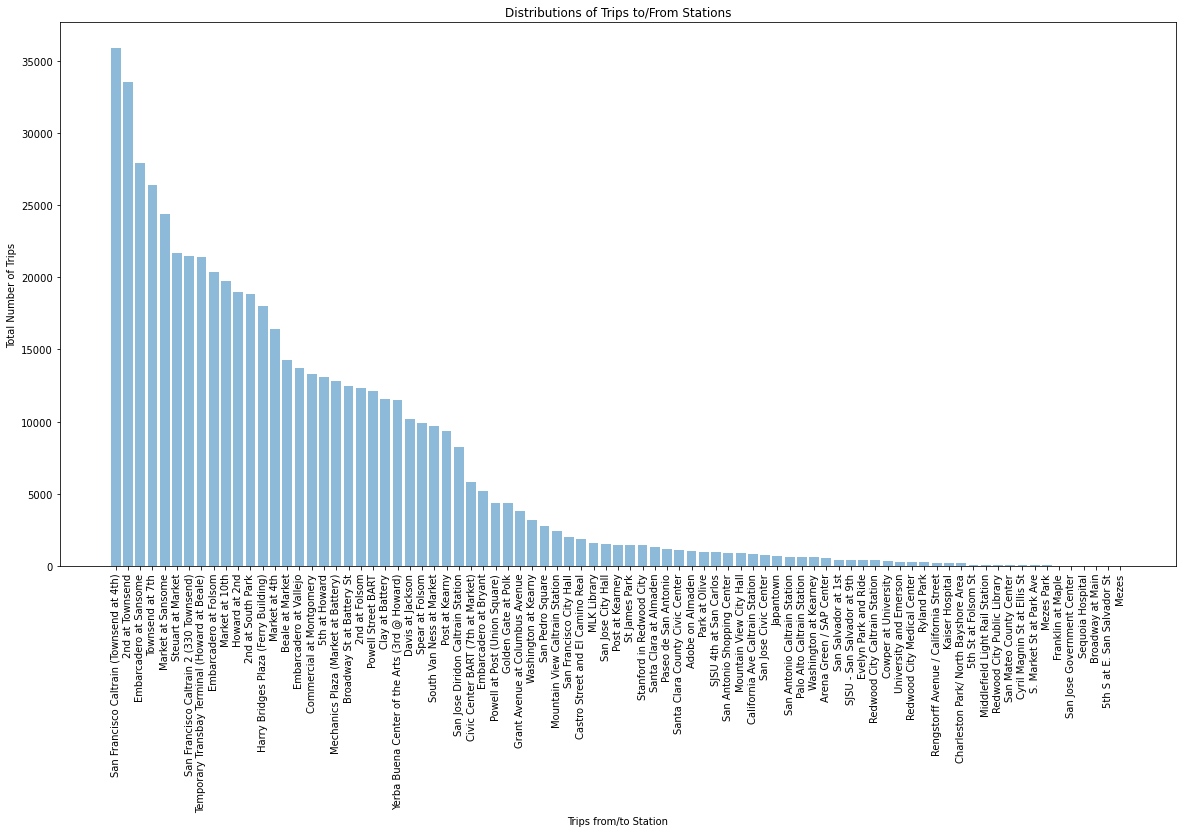

In [40]:
combinedstations = morningtripstations.add(eveningtripstations, fill_value=0).sort_values(by=['trip_id'], ascending=False)

# plotcombinedtripcounts = combinedtripcounts.head(40)
# stationindex = list(plotcombinedtripcounts.index.values)
# stationcontents = list(plotcombinedtripcounts['count'])

# plt.figure(figsize=(20,10))
# plt.bar(stationindex, stationcontents, alpha = 0.5)
# plt.title('Distributions of Trips')
# plt.xlabel('Trips from/to Station')
# plt.ylabel('Total Number of Trips')
# plt.xticks(rotation='vertical')

# plt.show


# plotcombinedtripcounts = combinedtripcounts.head(20)
stationindex = list(combinedstations.index.values)
stationcontents = list(combinedstations['trip_id'])

plt.figure(figsize=(20,10))
plt.bar(stationindex, stationcontents, alpha = 0.5)
plt.title('Distributions of Trips to/From Stations')
plt.xlabel('Trips from/to Station')
plt.ylabel('Total Number of Trips')
plt.xticks(rotation='vertical')

plt.show()


As we can see, there are many stations with barely any commuter activity.  Let's take a look at some of the stations least-used by commuters.

In [41]:
combinedstations = morningtripstations.add(eveningtripstations, fill_value=0).sort_values(by=['trip_id'], ascending=True)
combinedstations['count']=combinedstations['trip_id']
combinedstations[['count']].head(11)

,count
Mezes,2.0
5th S at E. San Salvador St,4.0
Sequoia Hospital,7.0
Broadway at Main,7.0
San Jose Government Center,8.0
Franklin at Maple,17.0
Mezes Park,22.0
S. Market St at Park Ave,26.0
Cyril Magnin St at Ellis St,27.0
San Mateo County Center,29.0


Now, let's take a look at some of the stations most used by commuters.

In [42]:
combinedstations = morningtripstations.add(eveningtripstations, fill_value=0).sort_values(by=['trip_id'], ascending=False)
combinedstations['count']=combinedstations['trip_id']
combinedstations[['count']].head(11)

,count
San Francisco Caltrain (Townsend at 4th),35896.0
2nd at Townsend,33538.0
Embarcadero at Sansome,27919.0
Townsend at 7th,26434.0
Market at Sansome,24368.0
Steuart at Market,21693.0
San Francisco Caltrain 2 (330 Townsend),21451.0
Temporary Transbay Terminal (Howard at Beale),21419.0
Embarcadero at Folsom,20380.0
Market at 10th,19722.0


As we can see, there is a massive disparity between the most-used stations and the least-used stations.  We can see that half the stations are used much more often than the other half.  These lesser-used stations are wasted assets, at least in terms of the commuter market.

# Recommendation 2


Some stations that are used much less than others.  While there are undoubtedly some stations that are more convenient than others, it could be beneficial to increase awareness of thse lesser-utilized stations; it is possible that these stations have been less used because of low awareness.  Possible solutions include increased advertising, promotional offers to remind people of these stations, and even creating an app that suggests possibly relevant stations depending on a commuting route.  

# Recommendation 3

There are also some stations that are used much more than others.  It may be worth looking at increasing bike capacity for those stations to better leverage their popularity.  Especially if we increase advertising/outreach and create new membership plans specifically for commuters, it makes sense to increase capacity of stations that are popular with commuters. If we run out of capacity of those stations, all the efforts to draw more commuter to the bikeshare services will quickly hit a ceiling.

## Relation between Caltrain and Station Popularity

Observing our distribution of station popularities, we can noticed that many of the popular commuter trips include stations near Caltrain stations.  For example, let's look at our top five most popular commuter trips again:

* Harry Bridges Plaza (Ferry Building) to/from 2nd at Townsend
* San Francisco Caltrain (Townsend at 4th) to/from Embarcadero at Folsom
* San Francisco Caltrain (Townsend at 4th) to/from Temporary Transbay Terminal (Howard at Beale)
* San Francisco Caltrain (Townsend at 4th) to/from Steuart at Market
* Steuart at Market to/from Embarcadero at Sansome


Three of our five most popular commuter trips involve San Francisco Caltrain (Townsend at 4th)!  Let's try to define the relation between station popularity and Caltrain.

In [43]:
# combinedstations = morningtripstations.add(eveningtripstations, fill_value=0).sort_values(by=['trip_id'], ascending=False)
# combinedstations['count']=combinedstations['trip_id']

combinedtripcounts.index.name = 'station_name'
combinedtripcounts.reset_index(inplace=True)
# combinedtripcounts.head()

regularstations = combinedtripcounts[~combinedtripcounts["station_name"].str.contains('Caltrain')]
caltrainstations = combinedtripcounts[combinedtripcounts['station_name'].str.contains('Caltrain')]

# caltrainstations.head()

print('Average trip count for all stations:')
print(regularstations['count'].mean())

print('Average trip count for stations near Caltrain:')
print(caltrainstations['count'].mean())

print('Standard deviation for trip count for all stations:')
print(regularstations['count'].std())

print('Standard deviation for trip count for stations near Caltrain:')
print(caltrainstations['count'].std())

# combinedstations = morningtripstations.add(eveningtripstations, fill_value=0).sort_values(by=['trip_id'], ascending=False)
# combinedstations['count']=combinedstations['trip_id']

# combinedstations.index.name = 'station_name'
# combinedstations.reset_index(inplace=True)
# combinedstations.head()

# regularstations = combinedstations[~combinedstations["station_name"].str.contains('Caltrain')]
# caltrainstations = combinedstations[combinedstations['station_name'].str.contains('Caltrain')]

# # caltrainstations.head()

# print('Average trip count for all stations:')
# print(combinedstations['count'].mean())

# print('Average trip count for stations near Caltrain:')
# print(caltrainstations['count'].mean())

# print('Standard deviation for trip count for all stations:')
# print(combinedstations['count'].std())

# print('Standard deviation for trip count for stations near Caltrain:')
# print(caltrainstations['count'].std())

Average trip count for all stations:
203.5964353914704
Average trip count for stations near Caltrain:
768.5980707395498
Standard deviation for trip count for all stations:
534.0488802147454
Standard deviation for trip count for stations near Caltrain:
1364.938761191404


The above statistics tell us a few things.  First, stations near Caltrain are more popular than the average station.  Second, they are consistently more popular than average stations.  Stations near Caltrain seem to perform consistently better than the average station.  Let's try to visualize the differences.

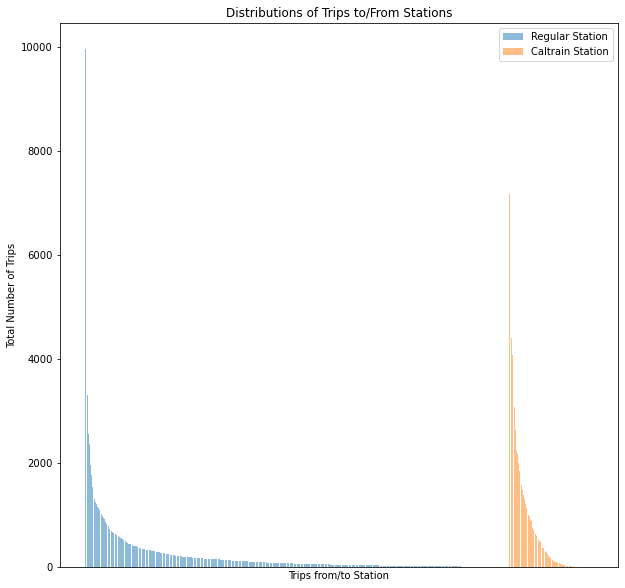

In [44]:
regularstationindex = list(regularstations['station_name'])
regularstationcontents = list(regularstations['count'])

caltrainstationindex = list(caltrainstations['station_name'])
caltrainstationcontents = list(caltrainstations['count'])

plt.figure(figsize=(10,10))
plt.bar(regularstationindex, regularstationcontents, label='Regular Station',alpha = 0.5)
plt.bar(caltrainstationindex, caltrainstationcontents, label='Caltrain Station',alpha = 0.5)

plt.title('Distributions of Trips to/From Stations')
plt.xlabel('Trips from/to Station')
plt.ylabel('Total Number of Trips')
# plt.xticks(rotation='vertical')
plt.xticks([])
plt.legend()
plt.show()


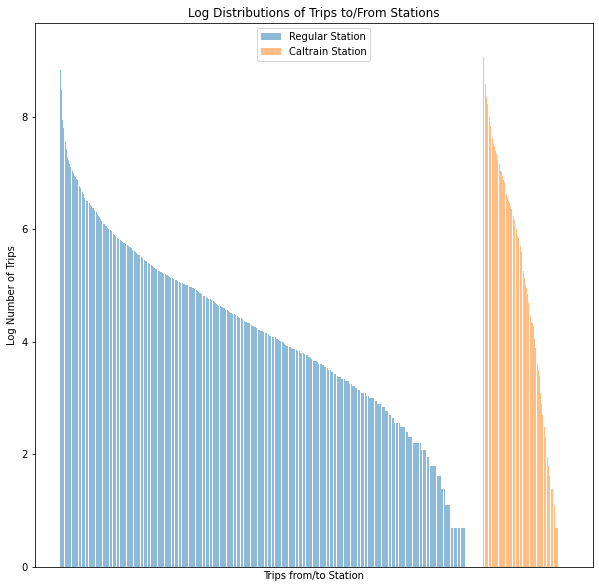

In [45]:
regularstationindex = list(regularstations['station_name'])
regularstationcontents = list(regularstations['count'])

caltrainstationindex = list(caltrainstations['station_name'])
caltrainstationcontents = list(caltrainstations['count'])

plt.figure(figsize=(10,10))
plt.bar(regularstationindex, np.log(regularstationcontents), label='Regular Station',alpha = 0.5)
plt.bar(caltrainstationindex, np.log(caltrainstationcontents), label='Caltrain Station',alpha = 0.5)

plt.title('Log Distributions of Trips to/From Stations')
plt.xlabel('Trips from/to Station')
plt.ylabel('Log Number of Trips')
# plt.xticks(rotation='vertical')
plt.xticks([])
plt.legend()
plt.show()


The distributions of regular stations and stations near Caltrain are noticeably different - the distinction is subtle, but the Caltrain station distribution is much steeper than the regular station distribution, and it is also greater on average.  This aligns with the statistics we calculated earlier - the Caltrain stations have a higher average popularity, but with a greater standard deviation.

What does this all mean?  The answer here isn't as clear as 'Caltrain Stations are always more successful so we should build more.'  But it serves as a reminder that we should be paying careful attention to how our bikesharing service relates to other transportation services in San Francisco.  It may be useful to determine how station popularity is determined by proximity to BART, bus, cablecar, or other bike/scooter share services.  From this single analysis, it seems that proximity to Caltrain may have some positive impact on the popularity of nearby bikeshare stations. 

# Recommendation 4

Examine the impact of the proximity of other transportation services on the popularity of bikeshare stations.  For example, stations near Caltrain appear to be more popular than the average station.  Intuitively, this makes some amount of sense - commuters use Caltrain or similar transport to arrive at/leave from San Francisco, and use bike-sharing stations to travel from the Caltrain station to wherever they need to travel within the city.  In this way, other transportation services like Caltrain or BART actually provide an opportunity for bike-sharing stations.  We could take advantage of this popularity by advertising or creating stations near Caltrain locations, or other transportation service locations.  We could even consider creating a partnership with Caltrain or other trasportation services to encourage commuters to use both services in conjunction with each other.

#### Are Commuters Subscribers or Customers?

It's also important to see how current commuters choose to pay for bikeshare services.  Let's find out whether commuters are subscribers or customers.

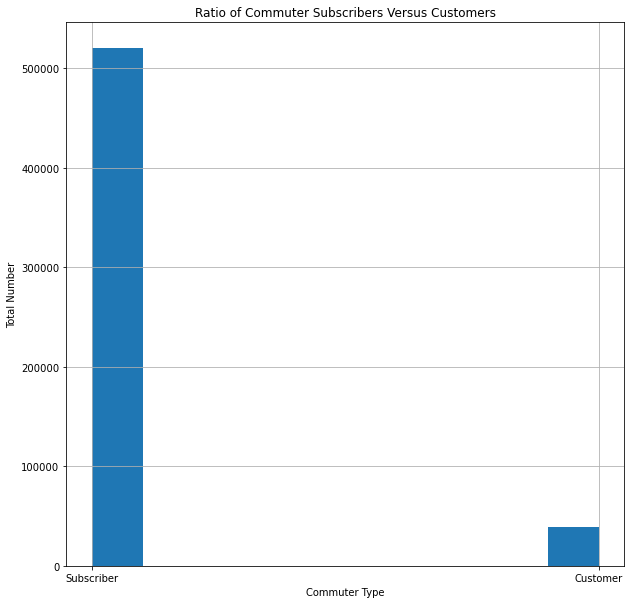

In [46]:
combined = pd.concat([morningtrips, eveningtrips])
c_index = ['Subscriber', 'Customer']
c_content = list(combined['subscriber_type'])

plt.figure(figsize=(10,10))
# plt.bar(c_index, c_content, alpha = 0.5)
combined['subscriber_type'].hist()
plt.title('Ratio of Commuter Subscribers Versus Customers')
plt.xlabel('Commuter Type')
plt.ylabel('Total Number')
# plt.xticks(rotation='vertical')

plt.show()


In [47]:
print('Number of Commuter Subscribers:')
print(combined[(combined['subscriber_type'] == 'Subscriber')].shape[0])

print()
print('Number of Commuter Customers:')
print(combined[(combined['subscriber_type'] == 'Customer')].shape[0])

print()
print('Fraction of Commuters that are Subscribers:')
print(combined[(combined['subscriber_type'] == 'Subscriber')].shape[0]/combined.shape[0])

print()
print('Fraction of Commuters that are Customers:')
print(combined[(combined['subscriber_type'] == 'Customer')].shape[0]/combined.shape[0])

Number of Commuter Subscribers:
520097

Number of Commuter Customers:
38787

Fraction of Commuters that are Subscribers:
0.9305991941082586

Fraction of Commuters that are Customers:
0.0694008058917414


As we can see, a good majority of our commuters are actually subscribers, which makes sense; regular constant trips fit a subscription, and it doesn't make much sense to pay individually for each commute.  What these statistics tell us is that the majority of our commuters recognize this fact - all we have to do now is take advantage of this fact.

# Recommendation 5

Most commuters using the bikeshare service are subscribers, rather than customers.  This is good - it shows that commuters naturally gravitate towards the existing membership models, and confirms our earlier recommendation to design membership models specifically for commuters.  We are left now with two approaches - to reach out to the remaining commuters who are not yet subscribers, and to adapt the subscription plans for the majority of commuters who use them.  First, we should reach out to the remaining commuters who are not yet subscribers to gain information as to why they are not yet subscribers, and to try to get them to become subscribers by way of increased advertising or special promotional offers.  

To that end, we should also consider expanding the number of available plans.  In Recommendation 1, we already discussed creating new membership plans to better fit the commuter demographic.  Now that we understand that most of our commuters are already subscribers, we can better tailor commuter plans even further.  We could try creating subscription plans of varying lengths, like quarterly or half-year plans.

### Where are commuters going to work?

Depending on where commuters are going to work, we could reach out to organizations and companies based in those areas to offer them corporate memberships/partnerships.  First, let's look at where commuters work.  Intuitively, this is equivalent to finding the morning end stations, or the evening starting stations.

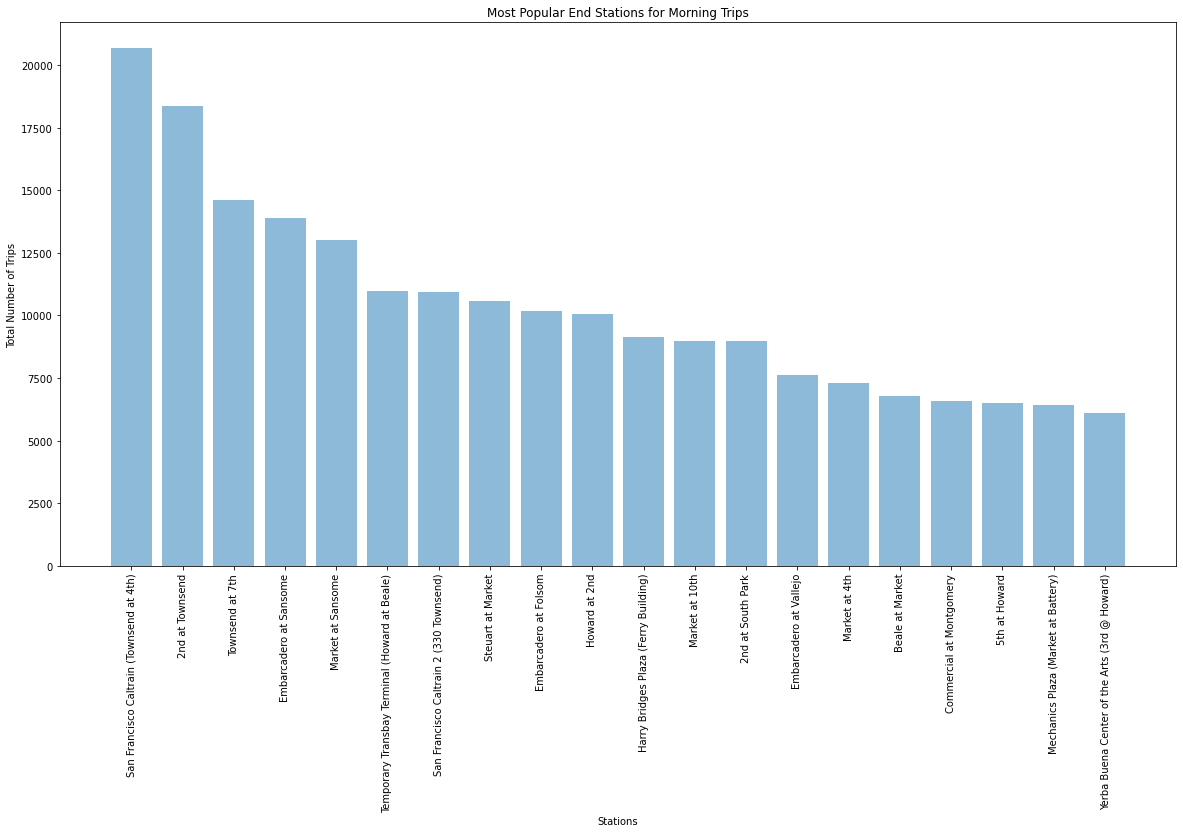

In [48]:
plotstations = morningtripstations.sort_values('trip_id', ascending = False).head(20)

stationindex = list(plotstations.index.values)
stationcontents = list(plotstations['trip_id'])

plt.figure(figsize=(20,10))
plt.bar(stationindex, stationcontents, alpha = 0.5)
plt.title('Most Popular End Stations for Morning Trips')
plt.xlabel('Stations')
plt.ylabel('Total Number of Trips')
plt.xticks(rotation='vertical')
plt.show()

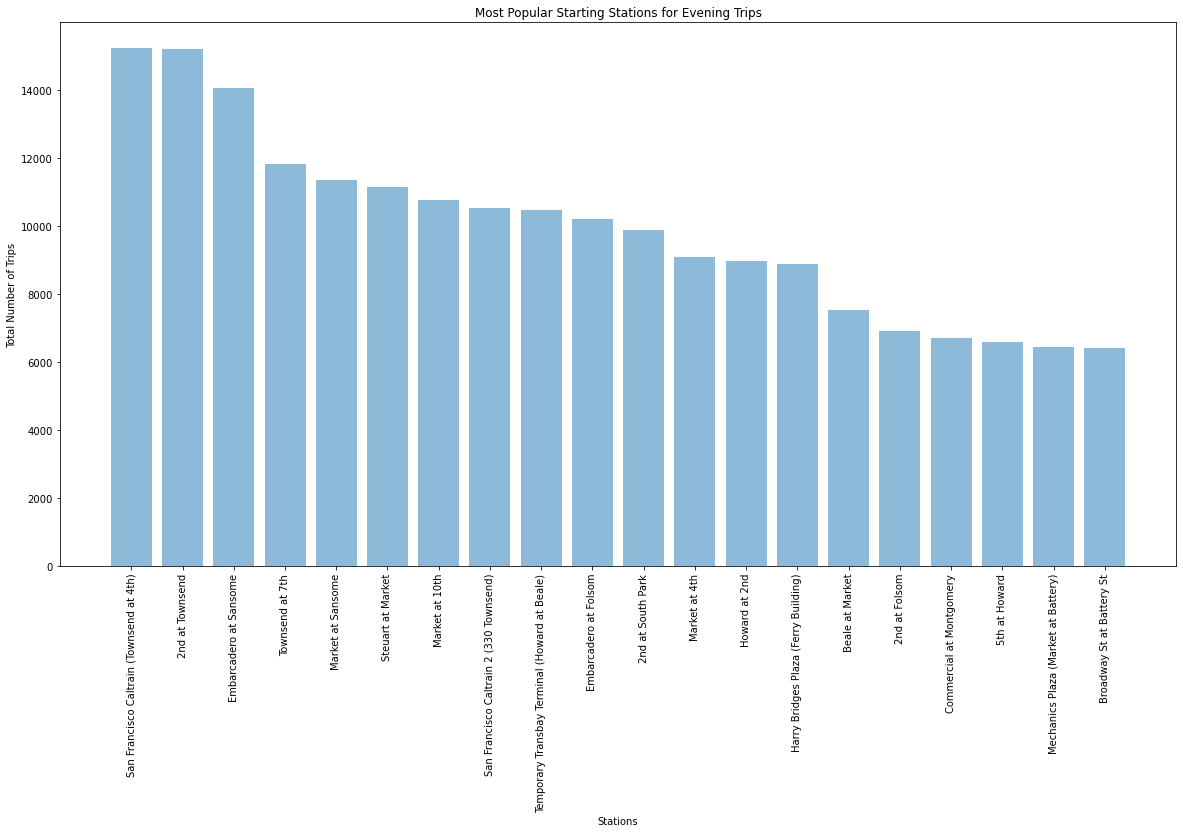

In [49]:
plotstations = eveningtripstations.sort_values('trip_id', ascending = False).head(20)

stationindex = list(plotstations.index.values)
stationcontents = list(plotstations['trip_id'])

plt.figure(figsize=(20,10))
plt.bar(stationindex, stationcontents, alpha = 0.5)
plt.title('Most Popular Starting Stations for Evening Trips')
plt.xlabel('Stations')
plt.ylabel('Total Number of Trips')
plt.xticks(rotation='vertical')
plt.show()

In [50]:
eveningtripstations.sort_values('trip_id', ascending = False).head(10)

,trip_id,duration_sec,start_date,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type,duration_minutes,duration_hours_rounded,duration_hours_tenths,dow_int,dow_str,dow_weekday,start_hour,start_hour_str
start_station_name,,,,,,,,,,,,,,,,,,
San Francisco Caltrain (Townsend at 4th),15222,15222,15222,15222,15222,15222,15222,15222,15188,15222,15222,15222,15222,15222,15222,15222,15222,15222
2nd at Townsend,15184,15184,15184,15184,15184,15184,15184,15184,15151,15184,15184,15184,15184,15184,15184,15184,15184,15184
Embarcadero at Sansome,14040,14040,14040,14040,14040,14040,14040,14040,13879,14040,14040,14040,14040,14040,14040,14040,14040,14040
Townsend at 7th,11809,11809,11809,11809,11809,11809,11809,11809,11800,11809,11809,11809,11809,11809,11809,11809,11809,11809
Market at Sansome,11354,11354,11354,11354,11354,11354,11354,11354,11315,11354,11354,11354,11354,11354,11354,11354,11354,11354
Steuart at Market,11129,11129,11129,11129,11129,11129,11129,11129,11074,11129,11129,11129,11129,11129,11129,11129,11129,11129
Market at 10th,10757,10757,10757,10757,10757,10757,10757,10757,10742,10757,10757,10757,10757,10757,10757,10757,10757,10757
San Francisco Caltrain 2 (330 Townsend),10515,10515,10515,10515,10515,10515,10515,10515,10502,10515,10515,10515,10515,10515,10515,10515,10515,10515
Temporary Transbay Terminal (Howard at Beale),10448,10448,10448,10448,10448,10448,10448,10448,10408,10448,10448,10448,10448,10448,10448,10448,10448,10448


In [51]:
morningtripstations.sort_values('trip_id', ascending = False).head(10)

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_id,bike_number,zip_code,subscriber_type,duration_minutes,duration_hours_rounded,duration_hours_tenths,dow_int,dow_str,dow_weekday,start_hour,start_hour_str
end_station_name,,,,,,,,,,,,,,,,,,
San Francisco Caltrain (Townsend at 4th),20674,20674,20674,20674,20674,20674,20674,20674,20654,20674,20674,20674,20674,20674,20674,20674,20674,20674
2nd at Townsend,18354,18354,18354,18354,18354,18354,18354,18354,18337,18354,18354,18354,18354,18354,18354,18354,18354,18354
Townsend at 7th,14625,14625,14625,14625,14625,14625,14625,14625,14613,14625,14625,14625,14625,14625,14625,14625,14625,14625
Embarcadero at Sansome,13879,13879,13879,13879,13879,13879,13879,13879,13770,13879,13879,13879,13879,13879,13879,13879,13879,13879
Market at Sansome,13014,13014,13014,13014,13014,13014,13014,13014,13001,13014,13014,13014,13014,13014,13014,13014,13014,13014
Temporary Transbay Terminal (Howard at Beale),10971,10971,10971,10971,10971,10971,10971,10971,10961,10971,10971,10971,10971,10971,10971,10971,10971,10971
San Francisco Caltrain 2 (330 Townsend),10936,10936,10936,10936,10936,10936,10936,10936,10929,10936,10936,10936,10936,10936,10936,10936,10936,10936
Steuart at Market,10564,10564,10564,10564,10564,10564,10564,10564,10526,10564,10564,10564,10564,10564,10564,10564,10564,10564
Embarcadero at Folsom,10173,10173,10173,10173,10173,10173,10173,10173,10168,10173,10173,10173,10173,10173,10173,10173,10173,10173


# Recommendation 6


We can see that there are some commonalities between the most popular end stations for morning trips and the most popular starting stations for evening trips.  These stations are likely close to where these commuters work, which means that we can look to arrange corporate partnerships/memberships with companies/organizations based in those areas.  From our visualizations, some good places to start would be locations near San Francisco Caltrain (Townsend at 4th), 2nd at Townsend, Embarcadero at Sansome, Townsend at 7th.  Arranging for these corporate partnerships/memberships will not only increase awareness and market space of our bikeshare service, it will also provide incentives for potential commuters to join our services.  This synergizes with our previous recommendations of advertising/creating bikeshare stations near local transportation and advertising/creating new membership plans geared towards commuters.

# Conclusion


## What are the 5 most popular trips that you would call "commuter trips"? 
  
  
The five most popular commuter trips are:

* Harry Bridges Plaza (Ferry Building) to/from 2nd at Townsend
* San Francisco Caltrain (Townsend at 4th) to/from Embarcadero at Folsom
* San Francisco Caltrain (Townsend at 4th) to/from Temporary Transbay Terminal (Howard at Beale)
* San Francisco Caltrain (Townsend at 4th) to/from Steuart at Market
* Steuart at Market to/from Embarcadero at Sansome


## What are your recommendations for offers (justify based on your findings)?

### Recommendation 1

We can offer cheaper plans that offer less minutes in order to attract more commuters.  Most commuters don't use the full 45 minutes, so we can offer them something fewer minutes at lower prices.  For example, a Yearly Commuter Membership that offers unlimited 25 minute rides for \\$100 a year, or a Monthly Commuter Membership that offers unlimited 25 minute rides for \\$10 a month.  It would be important to market these specifically to commuters in San Francisco, in order for the shorter minutes to be appealing to customers.


### Recommendation 2

Some stations that are used much less than others.  While there are undoubtedly some stations that are more convenient than others, it could be beneficial to increase awareness of thse lesser-utilized stations; it is possible that these stations have been less used because of low awareness.  Possible solutions include increased advertising, promotional offers to remind people of these stations, and even creating an app that suggests possibly relevant stations depending on a commuting route.  


### Recommendation 3

There are also some stations that are used much more than others.  It may be worth looking at increasing bike capacity for those stations to better leverage their popularity.  Especially if we increase advertising/outreach and create new membership plans specifically for commuters, it makes sense to increase capacity of stations that are popular with commuters. If we run out of capacity of those stations, all the efforts to draw more commuter to the bikeshare services will quickly hit a ceiling.

### Recommendation 4

Examine the impact of the proximity of other transportation services on the popularity of bikeshare stations.  For example, stations near Caltrain appear to be more popular than the average station.  Intuitively, this makes some amount of sense - commuters use Caltrain or similar transport to arrive at/leave from San Francisco, and use bike-sharing stations to travel from the Caltrain station to wherever they need to travel within the city.  In this way, other transportation services like Caltrain or BART actually provide an opportunity for bike-sharing stations.  We could take advantage of this popularity by advertising or creating stations near Caltrain locations, or other transportation service locations.  We could even consider creating a partnership with Caltrain or other trasportation services to encourage commuters to use both services in conjunction with each other.

### Recommendation 5

Most commuters using the bikeshare service are subscribers, rather than customers.  This is good - it shows that commuters naturally gravitate towards the existing membership models, and confirms our earlier recommendation to design membership models specifically for commuters.  We are left now with two approaches - to reach out to the remaining commuters who are not yet subscribers, and to adapt the subscription plans for the majority of commuters who use them.  First, we should reach out to the remaining commuters who are not yet subscribers to gain information as to why they are not yet subscribers, and to try to get them to become subscribers by way of increased advertising or special promotional offers.  

To that end, we should also consider expanding the number of available plans.  In Recommendation 1, we already discussed creating new membership plans to better fit the commuter demographic.  Now that we understand that most of our commuters are already subscribers, we can better tailor commuter plans even further.  We could try creating subscription plans of varying lengths, like quarterly or half-year plans.

### Recommendation 6


We can see that there are some common elements in both the most popular end stations for morning trips and the most popular starting stations for evening trips.  These stations are likely close to where these commuters work, which means that we can look to arrange corporate partnerships/memberships with companies/organizations based in those areas.  From our visualizations, some good places to start would be locations near San Francisco Caltrain (Townsend at 4th), 2nd at Townsend, Embarcadero at Sansome, Townsend at 7th.  Arranging for these corporate partnerships/memberships will not only increase awareness and market space of our bikeshare service, it will also provide incentives for potential commuters to join our services.  This synergizes with our previous recommendations of advertising/creating bikeshare stations near local transportation and advertising/creating new membership plans geared towards commuters.